In [1]:
# Dependencies
import requests
import json

import pandas as pd
from pandas_datareader import data
from pandas_datareader import wb

import numpy as np

import time
import datetime as dt
from datetime import datetime

import matplotlib.pyplot as plt

import scipy.stats as st
from scipy.stats import linregress
from scipy.stats import sem

import mplfinance as mpf

# Gather

## Financial Data Collection

Using the pandas DataReader library to request data from Yahoo Finance for the Cryptocurrencies and Stock Exchange information that will be sampled.

**Note:**  
Bitcoin ticker symbol is BTC-USD  
Etheremum ticker symbol is ETH-USD  
Dogecoin ticker symbol is DOGE-USD  
Cardano ticker symbol is ADA-USD  
DOW JONES ticker symbol is ^DJI  
NASDAQ ticker symbol is ^IXIC  

In [2]:
#create a list of cryptocurrencies
crypto_list=["BTC-USD","ETH-USD","DOGE-USD","ADA-USD",]

#define date range
start_d = "2018-06-01"
end_d = "2020-06-30"

#create dataframe
crypto_list_df = data.DataReader(crypto_list, "yahoo", start_d,end_d)

#create a list of Dow Jones and NASDAQ
stock_indexes_list =["^DJI","^IXIC"]

#create dataframe
stock_indexes_list_df = data.DataReader(stock_indexes_list, "yahoo", start_d,end_d)



## Social Media Data Collection

Read in previously called Reddit Comment Data.

In [3]:
bitcoin_comment_times = pd.read_csv('output/comments_bitcoin.csv', index_col = 0)
ethereum_comment_times = pd.read_csv('output/comments_ethereum.csv', index_col= 0)
cardano_comment_times = pd.read_csv('output/comments_cardano.csv', index_col= 0)
dogecoin_comment_times = pd.read_csv('output/comments_dogecoin.csv', index_col= 0)
nasdaq_comment_times = pd.read_csv('output/comments_nasdaq.csv', index_col= 0)
dow_comment_times = pd.read_csv('output/comments_dow.csv', index_col= 0)

C:\Users\12164\anaconda3\envs\PythonData\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


# Clean

## Financial

### Crypto Highs, Lows, Volumes, and Daily Range

In [4]:
#create cryptocurrency daily high dataframe and save to csv
crypto_high = crypto_list_df.High.rename(columns={"BTC-USD": "Bitcoin High", "ETH-USD": "Ethereum High","DOGE-USD":"Dogecoin High", "ADA-USD":"Cardano High", "Symbols":"" })
crypto_high.to_csv("output/crypto_high.csv")

#multiple indexes making Date a series
crypto_high_no_date_index = crypto_high.reset_index()

#filter out daily low
crypto_low = crypto_list_df.Low.rename(columns={"BTC-USD": "Bitcoin Low", "ETH-USD": "Ethereum Low","DOGE-USD":"Dogecoin Low", "ADA-USD":"Cardano Low" })
crypto_low.to_csv("output/crypto_low.csv")

#multiple indexes making Date a series
crypto_low_no_date_index = crypto_low.reset_index()

#filter out daily volume
crypto_volume = crypto_list_df.Volume.rename(columns={"BTC-USD": "Bitcoin Volume", "ETH-USD": "Ethereum Volume","DOGE-USD":"Dogecoin Volume", "ADA-USD":"Cardano Volume" })
crypto_volume.to_csv("output/crypto_volume.csv")

#multiple indexes making Date a series
crypto_volume_no_date_index = crypto_volume.reset_index()

date_range = crypto_volume_no_date_index["Date"]

In [5]:
crypto_volume = pd.read_csv("output/crypto_volume.csv", index_col= 0)
crypto_high = pd.read_csv("output/crypto_high.csv", index_col= 0)
crypto_low = pd.read_csv("output/crypto_low.csv", index_col= 0)

crypto_change = pd.merge(crypto_high, crypto_low, on = 'Date')
crypto_change['Bitcoin Difference'] = crypto_change['Bitcoin High'] - crypto_change['Bitcoin Low']
crypto_change['Ethereum Difference'] = crypto_change['Ethereum High'] - crypto_change['Ethereum Low']
crypto_change['Dogecoin Difference'] = crypto_change['Dogecoin High'] - crypto_change['Dogecoin Low']
crypto_change['Cardano Difference'] = crypto_change['Cardano High'] - crypto_change['Cardano Low']

### Stock High, Lows, Volumes, and Daily Range

In [6]:
#create stock daily high dataframe and save to csv
stock_indexes_list_high = stock_indexes_list_df.High.round(2).rename(columns={"^DJI": "Dow Jones High", "^IXIC":"NASDAQ High"})
stock_indexes_list_high.to_csv("output/stock_indexes_high.csv")

#create stock daily low dataframe and save to csv
stock_indexes_list_low = stock_indexes_list_df.Low.round(2).rename(columns={"^DJI": "Dow Jones Low", "^IXIC":"NASDAQ Low"})
stock_indexes_list_low.to_csv("output/stock_indexes_low.csv")

#create stock daily volume dataframe and save to csv
stock_indexes_list_volume = stock_indexes_list_df.Volume.rename(columns={"^DJI": "Dow Jones Volume", "^IXIC":"NASDAQ Volume"})
stock_indexes_list_volume.to_csv("output/stock_indexes_volume.csv")


In [7]:
stock_indexes_list_volume = pd.read_csv("output/stock_indexes_volume.csv", index_col= 0)
stock_indexes_high = pd.read_csv("output/stock_indexes_high.csv", index_col= 0)
stock_indexes_low = pd.read_csv("output/stock_indexes_low.csv", index_col= 0)

stock_change = pd.merge(stock_indexes_high, stock_indexes_low, on = 'Date')

stock_change['Dow Jones Difference'] = stock_change['Dow Jones High'] - stock_change['Dow Jones Low']
stock_change['NASDAQ Difference'] = stock_change['NASDAQ High'] - stock_change['NASDAQ Low']

## Social

### Join separate calls into one dataframe, changing the Timestamp into a readable data

In [8]:
bitcoin_comment_times['Exchange']= 'Bitcoin'
ethereum_comment_times['Exchange']= 'Ethereum'
cardano_comment_times['Exchange']= 'Cardano'
dogecoin_comment_times['Exchange']= 'Dogecoin'
nasdaq_comment_times['Exchange']= 'NASDAQ'
dow_comment_times['Exchange']= 'Dow Jones'

reddit_comments = pd.concat([bitcoin_comment_times, ethereum_comment_times, cardano_comment_times, dogecoin_comment_times, nasdaq_comment_times, dow_comment_times], ignore_index= True, keys = ('Bitcoin', 'Ethereum', 'Cardano', 'Dogecoin', 'NASDAQ', 'Dow Jones'))

reddit_comments['DateTime']= [datetime.fromtimestamp(i) for i in reddit_comments['Timestamp']]

reddit_comments['Date'] = reddit_comments['DateTime'].dt.date

reddit_comments_clean = reddit_comments[['Date', 'SubReddit', 'Exchange']]

reddit_comment_count = pd.DataFrame(reddit_comments_clean.groupby(['Exchange', 'Date']).count()).reset_index().rename(columns= {'SubReddit': 'Comment Count'})

In [9]:
bit_volume = crypto_volume[['Bitcoin Volume']]
bit_volume.reset_index(inplace=True)

bit_difference = crypto_change[['Bitcoin Difference']]
bit_difference.reset_index(inplace=True)

bit_comments = reddit_comment_count.loc[reddit_comment_count['Exchange']=='Bitcoin', ['Date', 'Comment Count']]
bit_comments.reset_index()
bit_comments['Date'] = [i.strftime("%Y-%m-%d") for i in bit_comments['Date']]

bit_vol_merged_df = pd.merge(bit_comments, bit_volume)
bit_merged_df = pd.merge(bit_vol_merged_df, bit_difference)

bit_count_merged = bit_merged_df['Comment Count']
bit_volume_merged = bit_merged_df['Bitcoin Volume']
bit_delta_merged = bit_merged_df['Bitcoin Difference']

In [10]:
ether_volume = crypto_volume[['Ethereum Volume']]
ether_volume.reset_index(inplace=True)

ether_difference = crypto_change[['Ethereum Difference']]
ether_difference.reset_index(inplace=True)

ether_comments = reddit_comment_count.loc[reddit_comment_count['Exchange']=='Ethereum', ['Date', 'Comment Count']]
ether_comments.reset_index()
ether_comments['Date'] = [i.strftime("%Y-%m-%d") for i in ether_comments['Date']]

ether_vol_merged_df = pd.merge(ether_comments, ether_volume)
ether_merged_df = pd.merge(ether_vol_merged_df, ether_difference)

ether_count_merged = ether_merged_df['Comment Count']
ether_volume_merged = ether_merged_df['Ethereum Volume']
ether_delta_merged = ether_merged_df['Ethereum Difference']

In [11]:
card_volume = crypto_volume[['Cardano Volume']]
card_volume.reset_index(inplace=True)

card_difference = crypto_change[['Cardano Difference']]
card_difference.reset_index(inplace=True)

card_comments = reddit_comment_count.loc[reddit_comment_count['Exchange']=='Cardano', ['Date', 'Comment Count']]
card_comments.reset_index()
card_comments['Date'] = [i.strftime("%Y-%m-%d") for i in card_comments['Date']]

card_vol_merged_df = pd.merge(card_comments, card_volume)
card_merged_df = pd.merge(card_vol_merged_df, card_difference)

card_count_merged = card_merged_df['Comment Count']
card_volume_merged = card_merged_df['Cardano Volume']
card_delta_merged = card_merged_df['Cardano Difference']

In [12]:
doge_volume = crypto_volume[['Dogecoin Volume']]
doge_volume.reset_index(inplace=True)

doge_difference = crypto_change[['Dogecoin Difference']]
doge_difference.reset_index(inplace=True)

doge_comments = reddit_comment_count.loc[reddit_comment_count['Exchange']=='Dogecoin', ['Date', 'Comment Count']]
doge_comments.reset_index()
doge_comments['Date'] = [i.strftime("%Y-%m-%d") for i in doge_comments['Date']]

doge_vol_merged_df = pd.merge(doge_comments, doge_volume)
doge_merged_df = pd.merge(doge_vol_merged_df, doge_difference)

doge_count_merged = doge_merged_df['Comment Count']
doge_volume_merged = doge_merged_df['Dogecoin Volume']
doge_delta_merged = doge_merged_df['Dogecoin Difference']

In [13]:
nasdaq_volume = stock_indexes_list_volume[['NASDAQ Volume']]
nasdaq_volume.reset_index(inplace=True)

nasdaq_difference = stock_change[['NASDAQ Difference']]
nasdaq_difference.reset_index(inplace=True)

nasdaq_comments = reddit_comment_count.loc[reddit_comment_count['Exchange']=='NASDAQ', ['Date', 'Comment Count']]
nasdaq_comments.reset_index()
nasdaq_comments['Date'] = [i.strftime("%Y-%m-%d") for i in nasdaq_comments['Date']]


nasdaq_vol_merged_df = pd.merge(nasdaq_comments, nasdaq_volume)
nasdaq_merged_df = pd.merge(nasdaq_vol_merged_df, nasdaq_difference)

nasdaq_count_merged = nasdaq_merged_df['Comment Count']
nasdaq_volume_merged = nasdaq_merged_df['NASDAQ Volume']
nasdaq_delta_merged = nasdaq_merged_df['NASDAQ Difference']

In [14]:
dow_volume = stock_indexes_list_volume[['Dow Jones Volume']]
dow_volume.reset_index(inplace=True)

dow_difference = stock_change[['Dow Jones Difference']]
dow_difference.reset_index(inplace=True)

dow_comments = reddit_comment_count.loc[reddit_comment_count['Exchange']=='Dow Jones', ['Date', 'Comment Count']]
dow_comments.reset_index()
dow_comments['Date'] = [i.strftime("%Y-%m-%d") for i in dow_comments['Date']]


dow_vol_merged_df = pd.merge(dow_comments, dow_volume)
dow_merged_df = pd.merge(dow_vol_merged_df, dow_difference)

dow_count_merged = dow_merged_df['Comment Count']
dow_volume_merged = dow_merged_df['Dow Jones Volume']
dow_delta_merged = dow_merged_df['Dow Jones Difference']

# Plot

### Cryptocurrency Daily Volume Over Time

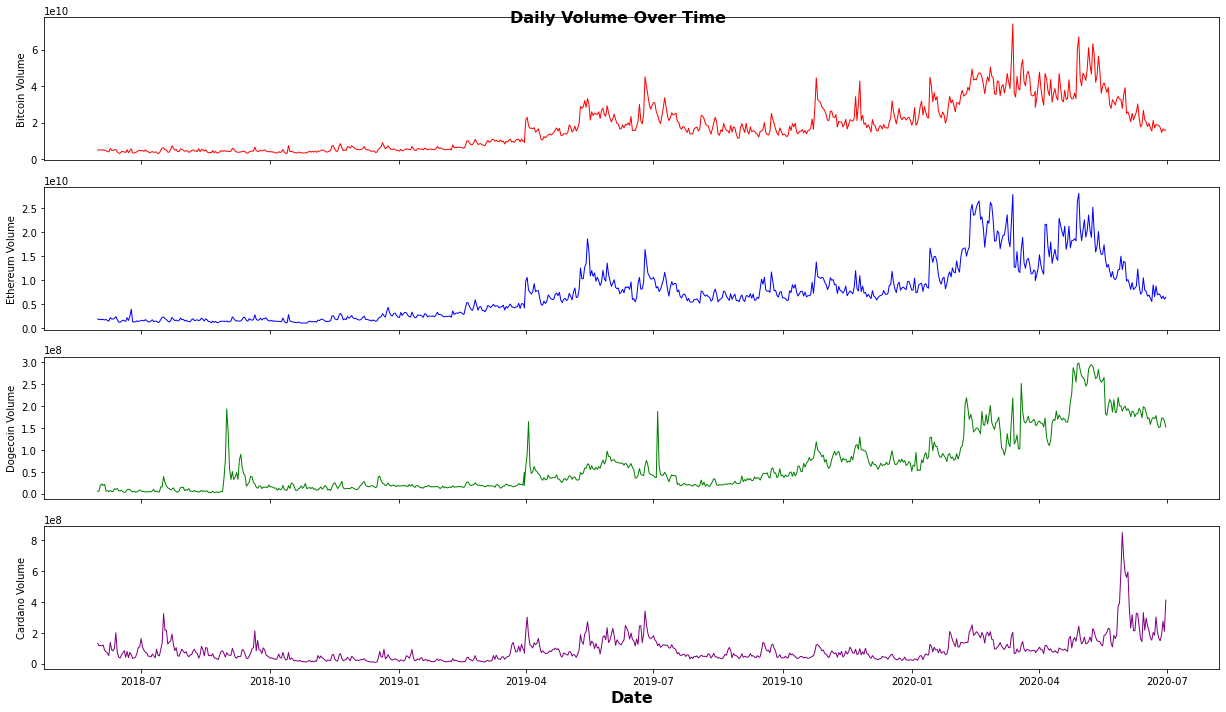

In [15]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True,figsize=(17,10))
fig.suptitle("Daily Volume Over Time", fontsize=16, fontweight="bold")

ax1.plot(date_range, crypto_volume["Bitcoin Volume"], linewidth=1, color ="red")
ax1.set_ylabel("Bitcoin Volume")

ax2.plot(date_range, crypto_volume["Ethereum Volume"], linewidth=1, color ="blue")
ax2.set_ylabel("Ethereum Volume")

ax3.plot(date_range, crypto_volume["Dogecoin Volume"], linewidth=1,color ="green")
ax3.set_ylabel("Dogecoin Volume")

ax4.plot(date_range, crypto_volume["Cardano Volume"], linewidth=1, color ="purple")
ax4.set_ylabel("Cardano Volume")
ax4.set_xlabel("Date", fontsize=16, fontweight="bold")

#save plot
plt.savefig("output/crypto_volume.png")

plt.tight_layout()
plt.show()

In [16]:
#define colors for candles
change_color = mpf.make_marketcolors(up ="green", down="red")
market_style = mpf.make_mpf_style(marketcolors = change_color)

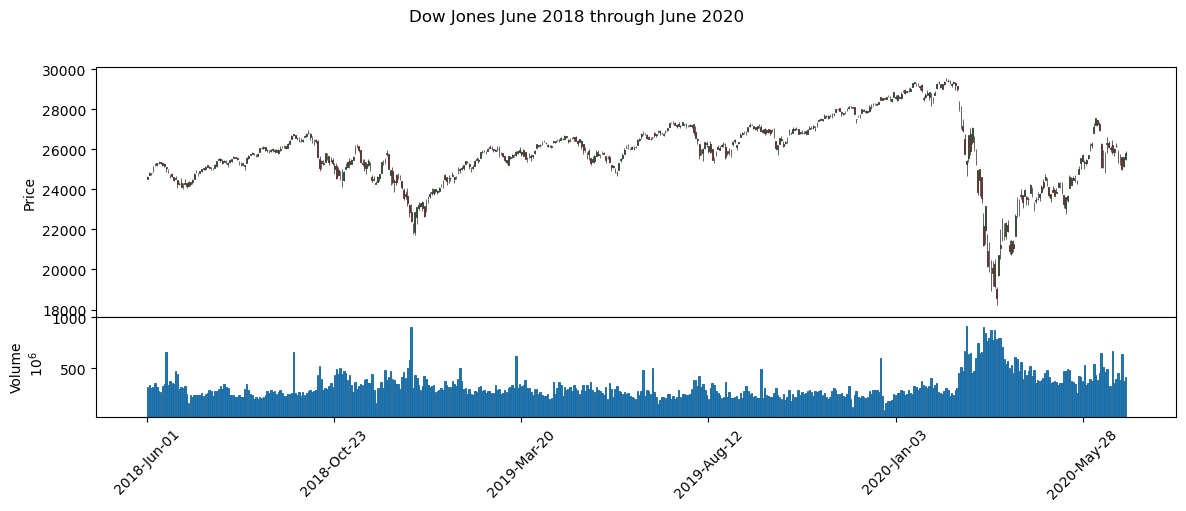

In [17]:
#Dow Jones price and volume june 2018 -june 2020
dow_june20 =data.DataReader("^DJI", "yahoo", "2018-06-01","2020-06-30")

#plot
dow_june20_plot = mpf.plot(dow_june20, type='candle', title='Dow Jones June 2018 through June 2020',ylabel='Price', ylabel_lower='Volume',volume=True, style = market_style,figsize=(15,5))

#save plot
dow_june20_plot = mpf.plot(dow_june20, type='candle', title='Dow Jones June 2018 through June 2020',ylabel='Price', ylabel_lower='Volume',volume=True, style = market_style,figsize=(15,5), savefig = ("output/dow_june2018-2020.png"))

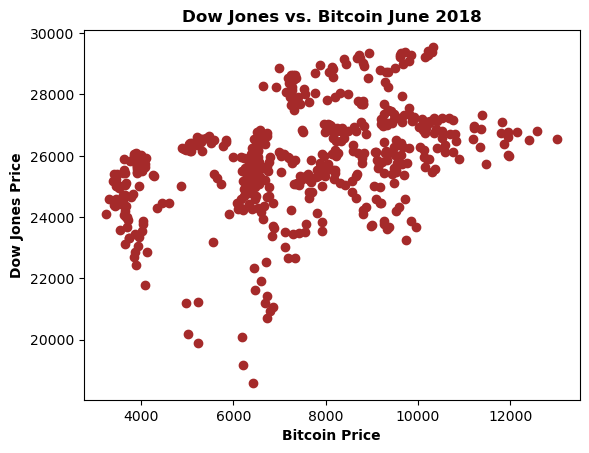

The correlation between Bitcoin and the Dow Jones in June 1, 2018 to June 30, 2020 is 0.4108021813174202


<Figure size 640x480 with 0 Axes>

In [18]:
#creat a list Bitcoin close price only
correlation_list =["BTC-USD"]
bitcoin_df = data.DataReader("BTC-USD", "yahoo", "2018-06-01","2020-06-30")
bitcoin_correlation_df = bitcoin_df.Close.round(2).rename({"BTC-USD":"Bitcoin Close Price"})
dow_df = data.DataReader("^DJI", "yahoo", "2018-06-01","2020-06-30")
dow_correlation_df = dow_df.Close.round(2).rename({"^DJI":"Dow Jones Close Price"})
merged_correlation_df = pd.merge(bitcoin_correlation_df, dow_correlation_df, on='Date')
clean_correlation_close = merged_correlation_df.rename(columns={"Close_x": "Bitcoin Close Price", "Close_y": "Dow Jones Close Price"})
xaxis = clean_correlation_close["Bitcoin Close Price"]
yaxis = clean_correlation_close["Dow Jones Close Price"]

plt.scatter(xaxis, yaxis, facecolor= "brown")
plt.xlabel("Bitcoin Price",fontweight="bold")
plt.ylabel("Dow Jones Price",fontweight="bold")
plt.title("Dow Jones vs. Bitcoin June 2018",fontweight="bold")

plt.savefig("output/dow_vs_bitcoin.png")
# Display plot
plt.show()
plt.tight_layout()

correlation = st.pearsonr(xaxis,yaxis)

#Print
print(f"The correlation between Bitcoin and the Dow Jones in June 1, 2018 to June 30, 2020 is {correlation[0]}")

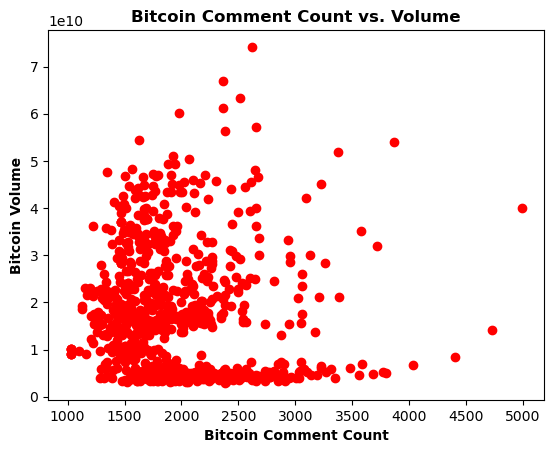

In [19]:
plt.scatter(bit_count_merged, bit_volume_merged,color ="red")
plt.xlabel("Bitcoin Comment Count",fontweight="bold")
plt.ylabel("Bitcoin Volume",fontweight="bold")
plt.title("Bitcoin Comment Count vs. Volume",fontweight="bold")

#save plot
plt.savefig("output/bitcoin_scatter_volume.png")

plt.show()

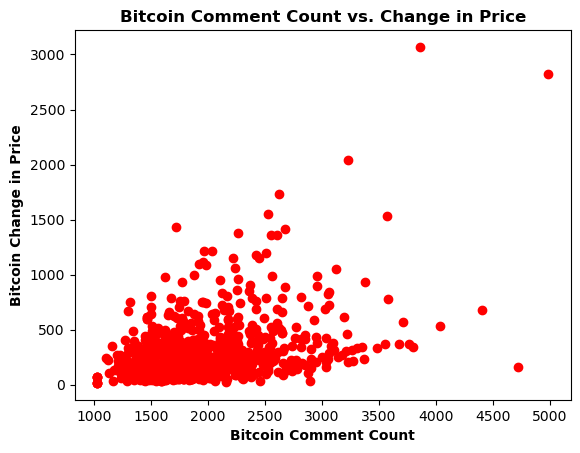

In [20]:
plt.scatter(bit_count_merged, bit_delta_merged,color ="red")
plt.xlabel("Bitcoin Comment Count",fontweight="bold")
plt.ylabel("Bitcoin Change in Price",fontweight="bold")
plt.title("Bitcoin Comment Count vs. Change in Price",fontweight="bold")

#save plot
plt.savefig("output/bitcoin_scatter.png")

plt.show()

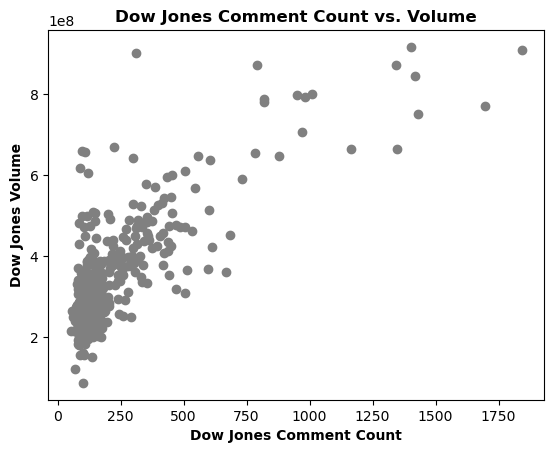

In [21]:
plt.scatter(dow_count_merged, dow_volume_merged,color ="gray")
plt.xlabel("Dow Jones Comment Count",fontweight="bold")
plt.ylabel("Dow Jones Volume",fontweight="bold")
plt.title("Dow Jones Comment Count vs. Volume",fontweight="bold")

#save plot
plt.savefig("output/dow_scatter_volume.png")

plt.show()

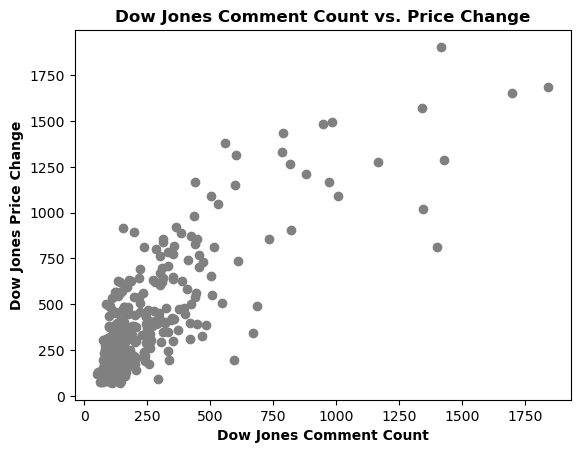

In [22]:
plt.scatter(dow_count_merged, dow_delta_merged, color ="gray")
plt.xlabel("Dow Jones Comment Count",fontweight="bold")
plt.ylabel("Dow Jones Price Change",fontweight="bold")
plt.title("Dow Jones Comment Count vs. Price Change",fontweight="bold")

#save plot
plt.savefig("output/dow_scatter.png")

plt.show()

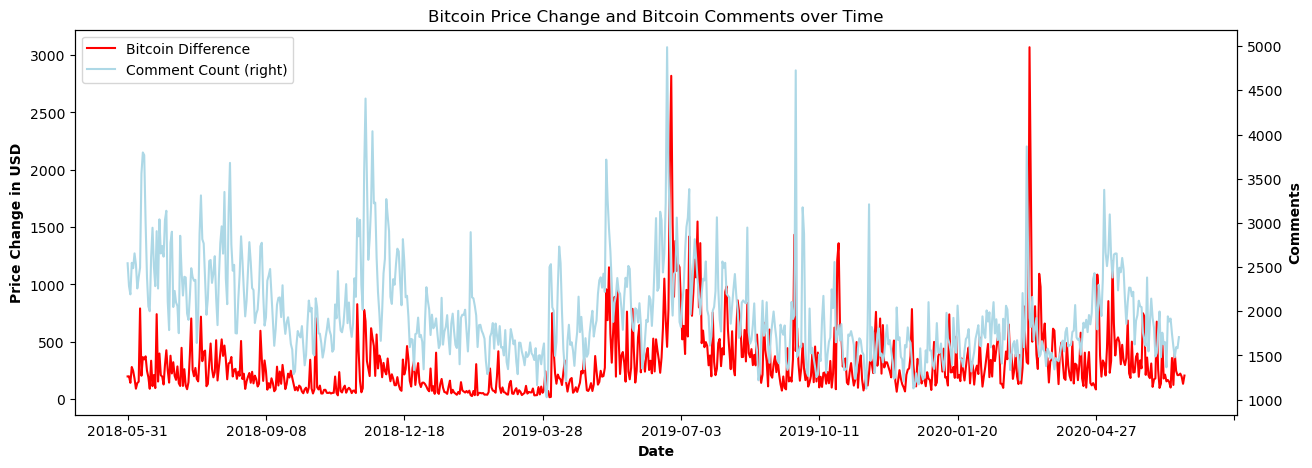

In [23]:
bitcoin_comment_vs_price = crypto_change[['Bitcoin Difference']].plot(color = 'red')

bit_comments.plot(ax = bitcoin_comment_vs_price, secondary_y = True,figsize=(15,5),title = "Bitcoin Price Change and Bitcoin Comments over Time", color = 'lightblue').set_ylabel("Comments",fontweight="bold")

bitcoin_comment_vs_price.set_xlabel("Date",fontweight="bold")
bitcoin_comment_vs_price.set_ylabel("Price Change in USD",fontweight="bold")


#save plot
plt.savefig("output/bitcoin_price_change_and_comments.png")

plt.show()

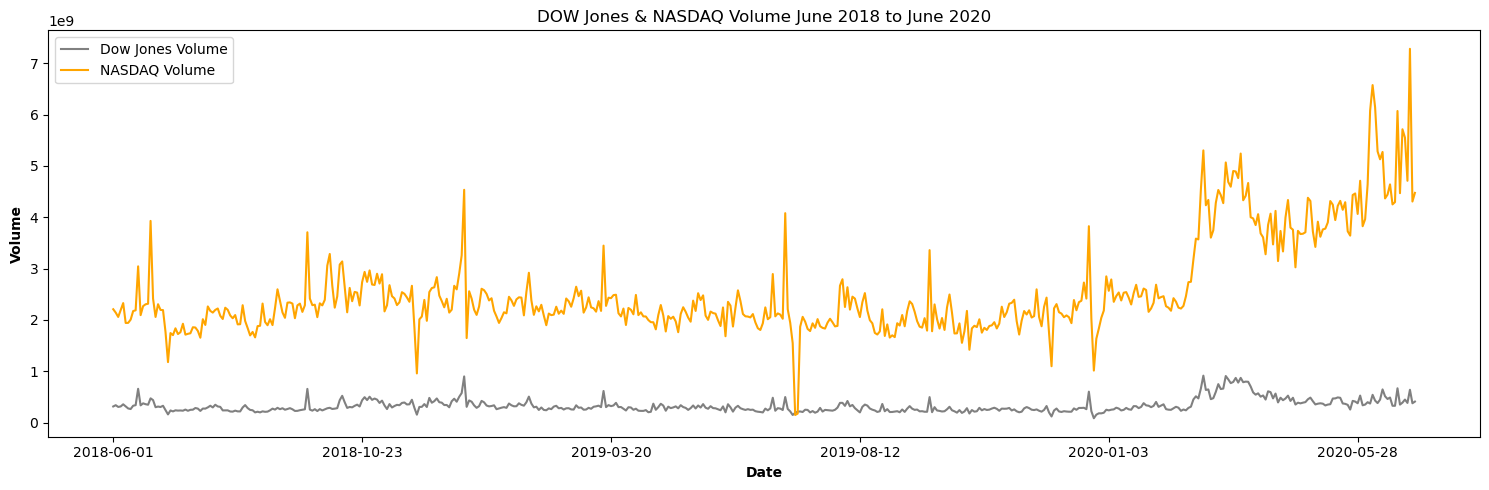

In [24]:
#Plot and set axises
colors = ('grey', 'orange')
two_yr_stock_indexes_volume = stock_indexes_list_volume[["Dow Jones Volume","NASDAQ Volume"]].plot(figsize=(15,5),title = "DOW Jones & NASDAQ Volume June 2018 to June 2020", color= colors)
two_yr_stock_indexes_volume.set_xlabel("Date",fontweight="bold")
two_yr_stock_indexes_volume.set_ylabel("Volume",fontweight="bold")

#save plot
plt.savefig("output/june2018_thru_june202_socke_indexes_volume.png")

#display
two_yr_stock_indexes_volume
plt.tight_layout()

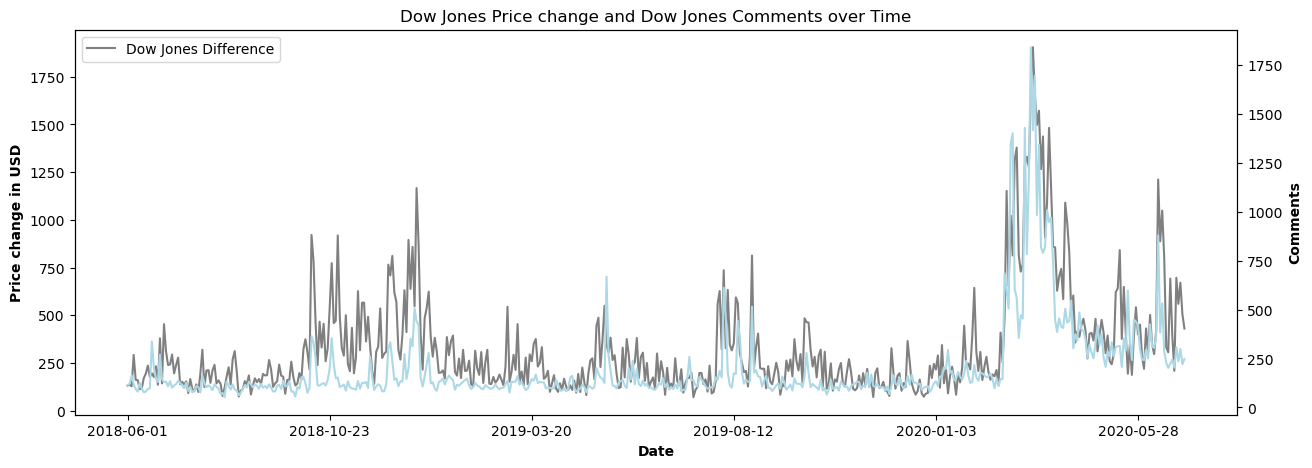

In [25]:
dow_comment_vs_price_change = stock_change[['Dow Jones Difference']].plot(color = 'grey')

dow_merged_df['Comment Count'].plot(ax = dow_comment_vs_price_change, secondary_y = True,figsize=(15,5),title = "Dow Jones Price change and Dow Jones Comments over Time", color= 'lightblue').set_ylabel("Comments",fontweight="bold")

dow_comment_vs_price_change.set_xlabel("Date",fontweight="bold")
dow_comment_vs_price_change.set_ylabel("Price change in USD",fontweight="bold")
dow_comment_vs_price_change.legend()

#save plot
plt.savefig("output/dow_price_change_and_comments.png")

plt.show()

# Analyze

In [26]:
bit_volume_correlation = st.pearsonr(bit_count_merged, bit_volume_merged)
bit_delta_correlation = st.pearsonr(bit_count_merged, bit_delta_merged)

ether_volume_correlation = st.pearsonr(ether_count_merged, ether_volume_merged)
ether_delta_correlation = st.pearsonr(ether_count_merged, ether_delta_merged)

card_volume_correlation = st.pearsonr(card_count_merged, card_volume_merged)
card_delta_correlation = st.pearsonr(card_count_merged, card_delta_merged)

doge_volume_correlation = st.pearsonr(doge_count_merged, doge_volume_merged)
doge_delta_correlation = st.pearsonr(doge_count_merged, doge_delta_merged)

nasdaq_volume_correlation = st.pearsonr(nasdaq_count_merged, nasdaq_volume_merged)
nasdaq_delta_correlation = st.pearsonr(nasdaq_count_merged, nasdaq_delta_merged)

dow_volume_correlation = st.pearsonr(dow_count_merged, dow_volume_merged)
dow_delta_correlation = st.pearsonr(dow_count_merged, dow_delta_merged)

print(f'''
Correlations between the time period of June 1, 2018 to June 30, 2020 are:

Bitcoin     Reddit Comments to Daily Volume      is {bit_volume_correlation[0]}. 
                            to Daily Price Range is  {bit_delta_correlation[0]}.

Ethereum    Reddit Comments to Daily Volume      is {ether_volume_correlation[0]}. 
                            to Daily Price Range is  {ether_delta_correlation[0]}.

Cardano     Reddit Comments to Daily Volume      is  {card_volume_correlation[0]}. 
                            to Daily Price Range is  {card_delta_correlation[0]}.     

Dogecoin    Reddit Comments to Daily Volume      is {doge_volume_correlation[0]}. 
                            to Daily Price Range is  {doge_delta_correlation[0]}.       

NASDAQ      Reddit Comments to Daily Volume      is  {nasdaq_volume_correlation[0]}. 
                            to Daily Price Range is  {nasdaq_delta_correlation[0]}.     

Dow Jones   Reddit Comments to Daily Volume      is  {dow_volume_correlation[0]}. 
                            to Daily Price Range is  {dow_delta_correlation[0]}.                        
''')


Correlations between the time period of June 1, 2018 to June 30, 2020 are:

Bitcoin     Reddit Comments to Daily Volume      is -0.07526784765363906. 
                            to Daily Price Range is  0.3839140636010183.

Ethereum    Reddit Comments to Daily Volume      is -0.4088386880987925. 
                            to Daily Price Range is  0.3928748907201369.

Cardano     Reddit Comments to Daily Volume      is  0.28517318862077634. 
                            to Daily Price Range is  0.2613143933181164.     

Dogecoin    Reddit Comments to Daily Volume      is -0.16291213768512133. 
                            to Daily Price Range is  0.4561820556493209.       

NASDAQ      Reddit Comments to Daily Volume      is  0.7394253806748537. 
                            to Daily Price Range is  0.4263275477851225.     

Dow Jones   Reddit Comments to Daily Volume      is  0.7775113642547149. 
                            to Daily Price Range is  0.8208300478702695.                 